In [46]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report
import torch
import matplotlib.pyplot as plt
import os

In [47]:
dataset_name = "2D_Laplc/"

#Configurpave to be dynamically adjusted
download_path = "../data/" #In the .gitignore list an

#n the rest of the code.
path_to_datasets = download_path + "/" + dataset_name 

In [48]:
# This cell now makes use of the downloadfolder for the datasets.
df_train= pd.read_csv(path_to_datasets + "/" + 'laplc_train.csv')
df_test=pd.read_csv(path_to_datasets + "/" +  'laplc_test.csv')
#print("Dataframes MITBIH correctly read into workspace")

#split target and value
train_target=df_train['p(x,y)']
test_target=df_test['p(x,y)']
train=df_train.drop('p(x,y)',axis=1)
test=df_test.drop('p(x,y)',axis=1)

In [49]:
df_train.sample(1)

,x,y,"p(x,y)"
0,0.0,0.0,0.0


In [50]:
Train_Simple_ANN = True #Trains the simple ANN

The following functions should normally be imported from the other script

In [51]:
def grad_x(p, len_x): 
    """Calculate the gradient of the input p in x-direction
       It assumes uniformly distributed nodes in a domain D=[0,1] x [0,1].
       Hence, len_x = len_y.
       Adjust coordinates and geometry if needed, or alternatively transform variables.
    """
    epsilon = 1e-8 #
    dX = 1.0/(len_x-1) #Spacing h is denoted with dX
    gradp_x=torch.zeros_like(p) + epsilon

    for i in range(1,len_x-1):
        for j in range(0,len_x):
            gradp_x[i*len_x+j] = (p[(i+1)*len_x+j] - p[(i-1)*len_x+j]) * 0.5/dX

    #One-sided gradient for @ x=0. It means i==0. 
    for j in range(0,len_x):
        gradp_x[j] = ( -p[2*len_x+j] +4*p[len_x+j] - 3*p[j]) * 0.5/dX


    #One-sided gradient for @ x=1. It means i==lenX-1. Second-order accurate
    for j in range(0,len_x):
        gradp_x[(len_x-1)*len_x+j] =  (3*p[(len_x-1)*len_x+j] - 4*p[(len_x-2)*len_x+j] + p[(len_x-3)*len_x+j]) * 0.5/dX

    return gradp_x

In [52]:
def grad_y(p, len_x): 
    """Calculate the gradient of the input p in y-direction
       It assumes uniformly distributed nodes in a domain D=[0,1] x [0,1].
       Hence, len_x = len_y.
       Adjust coordinates and geometry if needed, or alternatively transform variables.
    """
    epsilon = 1e-8 #
    dX = 1.0/(len_x-1) #Spacing h is denoted with dX
    gradp_y=torch.zeros_like(p) + epsilon

    for i in range(0,len_x):
        for j in range(1,len_x-1):
            gradp_y[i*len_x+j] = (p[i*len_x+j+1] - p[i*len_x+j-1]) * 0.5/dX

    # One-sided @ y=0. Corresponds j=0.
    for i in range(0,len_x):
            gradp_y[i*len_x] = (-p[i*len_x+2] + 4*p[i*len_x+1] - 3*p[i*len_x]) * 0.5/dX

    # One-sided @ y=1. Corresponds j=lenY-1.
    for i in range(0,len_x):
            gradp_y[(i+1)*len_x-1] = (-p[(i+1)*len_x-3] + 4*p[(i+1)*len_x-2] - 3*p[(i+1)*len_x-1]) * 0.5/dX
    
    return gradp_y

## **Simple Artificial Neural Network**
ANN without convolutional layers. Only Dense layers are used. No Pooling, Flattening or Dropping out. Base model for later comparison.

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Implement Torch Dataset object

In [54]:
class PDE_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, target_transform=None):
        self.dataframe = csv_file.values
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataframe)
        #return self.dataframe.shape[0] # Alternative notation

    def __getitem__(self, idx):
        inputs = torch.tensor(self.dataframe[idx,:-1], requires_grad=True).to(torch.float32)
        label = torch.tensor(self.dataframe[idx,-1]).to(torch.float32)

        return inputs, label

Custom function for preprocessing (to elaborate later, currently just returns the input itself)

In [55]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x * torch.Tensor([1.0])

In [56]:
# Define the ANN model
class SimpleANN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc0 = nn.Sequential(Lambda(preprocess))
        self.fc1 = nn.Linear(input_size, 24)
        self.fc2 = nn.Linear(24, 48)  
        self.fc3 = nn.Linear(48, 24) 
        self.fc4 = nn.Linear(24, 12)  
        self.fc5 = nn.Linear(12, output_size)  # Hidden to output layer
        self.fc6 = nn.Linear(6, output_size)  # Hidden to output layer
        self.relu = nn.LeakyReLU(negative_slope=0.001)    # Activation function
        self.dropout = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        #x = self.fc0(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [58]:
lenX = int(np.sqrt(len(df_train)))
lenY = lenX
batch_size = 36
lambdaDBC = 1 #Weight factor for the Dirichlet loss. 
kappa = 0

In [59]:
def target_func(x,y): 
    pres = x*x - y*y
    return pres

In [60]:
class DirichletBC(nn.Module):
    def __init__(self):
        super(DirichletBC, self).__init__()

    def forward(self, inputs, target_func, kappa):
        """
        Impose Dirichlet BC on the boundary.
        Args:
        Returns:
            torch.Tensor: Computed loss (scalar).
        """
        DirichletValues = []
        DirichletIndex = []

        for i, (x,y) in enumerate(inputs):
            if x==0 or x==1 or y==0 or y==1:
                DirichletValues.append(target_func(inputs[i,0], inputs[i,1]))
                DirichletIndex.append(i)
        
        DirichletValues = torch.tensor(DirichletValues,requires_grad=True)
        DirichletIndex = torch.tensor(DirichletIndex,requires_grad=False)
                   
        return DirichletIndex.unsqueeze(1), DirichletValues.unsqueeze(1)

In [61]:
def get_data(train_ds, valid_ds, bs, shuffle):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=shuffle),
        DataLoader(valid_ds, batch_size=bs),
    )

In [62]:
train_ds = PDE_Dataset(df_train)
test_ds = PDE_Dataset(df_test)
train_dl, test_dl = get_data(train_ds, test_ds, batch_size, shuffle=False)

Apply Boundary Conditions

In [63]:
bc = DirichletBC()
for inputs, labels in train_dl:
    # Watch out here. This calculated assuming one batch size=dataset_len
        
    DirichletIndx, DirichletVals = bc(inputs,target_func, kappa)

In [64]:
def batch_loss_train(outputs, labels, inputs, kappa, loss_fn, optimizer):
    loss = loss_fn(outputs, labels, inputs, kappa)
    
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    return loss.item()

In [65]:
def batch_loss_test(outputs, labels, loss_fn):
    loss = loss_fn(outputs, labels)    
    return loss.item()

In [66]:
def test_loop(dataloader, model, loss_fn, print_every, epoch):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, mse, mape = 0, 0, 0
    epsilon = 1e-8

    # Evaluating the model with torch.no_grad()    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            #print(pred.view(lenX,lenX))
            # test_loss += loss_fn(pred, y, X,kappa) / len(X)
            mse += torch.sum((y - pred) ** 2).item()
            #y = y + epsilon 
            mape += torch.mean(torch.abs((y - pred))) 

    if epoch % print_every == 0:
       print(f"Test set => Mean Squared error: {(mse/size):>0.4f}, Mean Abs error: {mape:>8f} \n")

In [67]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every, epoch):
    model.train()
    optimizer.zero_grad()
    train_loss = 0.0
    #all_outputs = torch.empty(0, 1, requires_grad=True)
    
    for inputs, labels in dataloader:
        # forward pass. Better without shuffle to keep the coordinates sorted
        
        outputs = model(inputs)
        #print(outputs.view(lenX,lenX))

        train_loss += batch_loss_train(outputs,labels,lenX,lenY,loss_fn, optimizer)
    
    if epoch % print_every == 0:
        print(f"Epoch {epoch+1}   -------------------------------")
        print(f'Train loss: {train_loss}')
    

In [68]:
mse_loss = nn.MSELoss()

In [69]:
class LaplaceLoss(nn.Module):
    def __init__(self):
        super(LaplaceLoss, self).__init__()

    def forward(self, preds, targets, len_x, len_y):
        """
        Compute the Calculate the Laplace eq. for predictions.
        labels (targets) should satisfy zero anyway
        """
                            
        gradp_x = grad_x(preds,len_x)
        gradp_y = grad_y(preds,len_y)

        grad_p_xx = grad_x(gradp_x,len_x)
        grad_p_yy = grad_y(gradp_y,len_y)
        laplacian = grad_p_xx + grad_p_yy 
        PDELoss = mse_loss(laplacian, torch.zeros_like(laplacian))

        # Dirichlet BC loss
        DBCpreds = preds[DirichletIndx.squeeze(1)].clone()
        DBCLoss = mse_loss(DBCpreds, DirichletVals)

        loss = PDELoss.sum() + lambdaDBC * DBCLoss.sum()
        
        return loss


In [70]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    print_every = 50
    for epoch in range(epochs):  
        train_loop(train_dl, model, loss_fn, optimizer, print_every, epoch)
        test_loop(train_dl, model, loss_fn, print_every, epoch)


In [71]:
# Define the model
torch.set_printoptions(precision=6)

input_size = 2  # Number of input features
output_size = 1  # Output size (e.g., regression or binary classification)
model = SimpleANN(input_size, output_size)

# Define loss and optimizer
criterion =  LaplaceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
fit(500, model, criterion, optimizer, train_dl, test_dl)

Epoch 1   -------------------------------
Train loss: 0.4153374135494232
Test set => Mean Squared error: 10.4288, Mean Abs error: 0.434733 

Epoch 51   -------------------------------
Train loss: 0.3192237615585327
Test set => Mean Squared error: 9.2143, Mean Abs error: 0.396774 

Epoch 101   -------------------------------
Train loss: 0.16669592261314392
Test set => Mean Squared error: 11.7839, Mean Abs error: 0.459675 

Epoch 151   -------------------------------
Train loss: 0.11586720496416092
Test set => Mean Squared error: 13.7930, Mean Abs error: 0.498150 

Epoch 201   -------------------------------
Train loss: 0.09936485439538956
Test set => Mean Squared error: 15.0129, Mean Abs error: 0.519896 

Epoch 251   -------------------------------
Train loss: 0.09176865965127945
Test set => Mean Squared error: 15.4133, Mean Abs error: 0.526316 

Epoch 301   -------------------------------
Train loss: 0.08856949955224991
Test set => Mean Squared error: 15.5965, Mean Abs error: 0.528913 

In [73]:
with torch.no_grad():
    for X, y in train_dl:
        prediction = model(X)
        labels = y

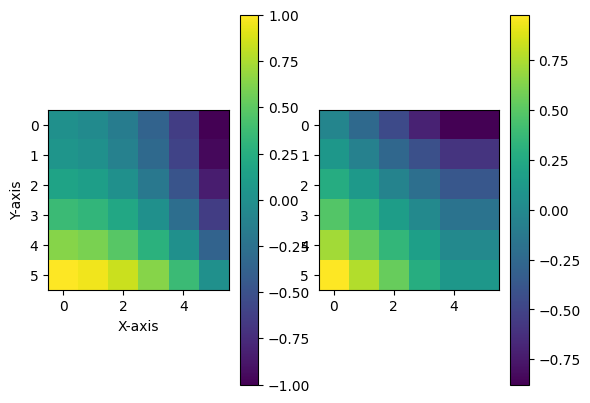

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 2D array
x = np.linspace(0,1,lenX)
y = np.linspace(0,1,lenY)
X, Y = np.meshgrid(x, y)     # Create a grid
Z1 = labels.view(lenX,lenY).detach()
Z2 = prediction.view(lenX,lenY).detach()

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot the surface
surface1 = ax.imshow(Z1)
surface2 = ax2.imshow(Z2)

# Add a color bar for reference
fig.colorbar(surface1)
fig.colorbar(surface2)

# Label axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.show()
